In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy
import math
import os
import glob
import time
import pandas as pd

# Grab ground truth data

In [2]:
X = torch.load("/scratch/04703/sravula/UTAFSDataNew/NEW_DATA.pt")
F = torch.load("/scratch/04703/sravula/UTAFSDataNew/NEW_FREQUENCIES.pt")

In [3]:
for i in range(len(X)):
    if X[i] is None:
        continue
        
    X[i] = X[i].squeeze(0)

In [4]:
print(len(X))

62


In [5]:
print(X[0].shape)
print(X[0].dtype)

torch.Size([2, 40, 3])
torch.float32


In [6]:
print(F[0].shape)

torch.Size([40])


# Now for DIP

In [7]:
dip_results_root = "/scratch/04703/sravula/dip_results/run_1"

In [8]:
DIP_chips = []
DIP_1 = []
DIP_2 = []
DIP_5 = []
DIP_10 = []

for i in range(1, 62):
    cur_dir = os.path.join(dip_results_root, "chip"+str(i))
    
    if not os.path.exists(cur_dir):
        continue
    
    file1 = os.path.join(cur_dir, "1.pt")
    file2 = os.path.join(cur_dir, "2.pt")
    file5 = os.path.join(cur_dir, "5.pt")
    file10 = os.path.join(cur_dir, "10.pt")
    
    file_check = [os.path.exists(file1), os.path.exists(file2), os.path.exists(file5), os.path.exists(file10)]
    if not any(file_check):
        continue
    
    DIP_chips.append(i)
    DIP_1.append(torch.load(file1).squeeze(0))
    DIP_2.append(torch.load(file2).squeeze(0))
    DIP_5.append(torch.load(file5).squeeze(0))
    DIP_10.append(torch.load(file10).squeeze(0))

In [9]:
print(DIP_chips)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23]


In [10]:
print(DIP_1[4].shape)
print(DIP_1[4].dtype)

torch.Size([2, 1001, 10])
torch.float32


# Finally grab VF data

In [11]:
vf_results_root = "/scratch/04703/sravula/dip_results/vf"

In [12]:
VF_chips = []
VF_1 = []
VF_2 = []
VF_5 = []
VF_10 = []

for i in DIP_chips:
    chip1_pth = os.path.join(vf_results_root, "case"+str(i)+"_1.npy")
    chip2_pth = os.path.join(vf_results_root, "case"+str(i)+"_2.npy")
    chip5_pth = os.path.join(vf_results_root, "case"+str(i)+"_5.npy")
    chip10_pth = os.path.join(vf_results_root, "case"+str(i)+"_10.npy")
    
    chip1 = np.load(chip1_pth, allow_pickle=True)
    chip2 = np.load(chip2_pth, allow_pickle=True)
    chip5 = np.load(chip5_pth, allow_pickle=True)
    chip10 = np.load(chip10_pth, allow_pickle=True)
    
    vf_chip_check = [chip1.shape == (), chip2.shape == (), chip5.shape == (), chip10.shape == ()]
    if any(vf_chip_check):
        continue
    
    VF_chips.append(i)
    VF_1.append(chip1)
    VF_2.append(chip2)
    VF_5.append(chip5)
    VF_10.append(chip10)

In [13]:
print(len(VF_chips))
print(VF_chips)

7
[5, 7, 9, 10, 15, 20, 23]


In [14]:
print(VF_1[0].shape)
print(VF_1[0].dtype)

(1001, 4, 4)
complex128


# Reconcile the different Data formats

## Make the VF arrays into [re/im, num_freqs, unique_sparams] float32 format

In [15]:
for t in range(len(VF_1)):
    data = VF_1[t]
    
    num_ports = data.shape[-1]
    num_freqs = data.shape[0]
    num_unique = (num_ports + 1) * num_ports // 2
    
    cur_data = np.zeros((2, num_freqs, num_unique))
    
    cur_idx = 0
    for i in range(num_ports):
        for j in range(i, num_ports):
            val = data[:, i, j]
            val = np.stack((val.real, val.imag)).astype(np.float32)
            
            cur_data[:, :, cur_idx] = copy.deepcopy(val)
            
            cur_idx = cur_idx + 1
    
    VF_1[t] = copy.deepcopy(cur_data.astype(np.float32))

In [16]:
print(VF_1[0].shape)
print(VF_1[0].dtype)

(2, 1001, 10)
float32


In [17]:
for t in range(len(VF_2)):
    data = VF_2[t]
    
    num_ports = data.shape[-1]
    num_freqs = data.shape[0]
    num_unique = (num_ports + 1) * num_ports // 2
    
    cur_data = np.zeros((2, num_freqs, num_unique))
    
    cur_idx = 0
    for i in range(num_ports):
        for j in range(i, num_ports):
            val = data[:, i, j]
            val = np.stack((val.real, val.imag)).astype(np.float32)
            
            cur_data[:, :, cur_idx] = copy.deepcopy(val)
            
            cur_idx = cur_idx + 1
    
    VF_2[t] = copy.deepcopy(cur_data.astype(np.float32))

In [18]:
print(VF_2[0].shape)
print(VF_2[0].dtype)

(2, 1001, 10)
float32


In [19]:
for t in range(len(VF_5)):
    data = VF_5[t]
    
    num_ports = data.shape[-1]
    num_freqs = data.shape[0]
    num_unique = (num_ports + 1) * num_ports // 2
    
    cur_data = np.zeros((2, num_freqs, num_unique))
    
    cur_idx = 0
    for i in range(num_ports):
        for j in range(i, num_ports):
            val = data[:, i, j]
            val = np.stack((val.real, val.imag)).astype(np.float32)
            
            cur_data[:, :, cur_idx] = copy.deepcopy(val)
            
            cur_idx = cur_idx + 1
    
    VF_5[t] = copy.deepcopy(cur_data.astype(np.float32))

In [20]:
print(VF_5[0].shape)
print(VF_5[0].dtype)

(2, 1001, 10)
float32


In [21]:
for t in range(len(VF_10)):
    data = VF_10[t]
    
    num_ports = data.shape[-1]
    num_freqs = data.shape[0]
    num_unique = (num_ports + 1) * num_ports // 2
    
    cur_data = np.zeros((2, num_freqs, num_unique))
    
    cur_idx = 0
    for i in range(num_ports):
        for j in range(i, num_ports):
            val = data[:, i, j]
            val = np.stack((val.real, val.imag)).astype(np.float32)
            
            cur_data[:, :, cur_idx] = copy.deepcopy(val)
            
            cur_idx = cur_idx + 1
            
    VF_10[t] = copy.deepcopy(cur_data.astype(np.float32))

In [22]:
print(VF_10[0].shape)
print(VF_10[0].dtype)

(2, 1001, 10)
float32


## Make the DIP results numpy

In [23]:
#want to make a list with the indices of the DIP_chips list whose values match VF_chips
cross_ref_idx = []

for i in range(len(VF_chips)):
    chip_idx = VF_chips[i]
    
    for j in range(len(DIP_chips)):
        dip_chip_idx = DIP_chips[j]
        
        if dip_chip_idx == chip_idx:
            cross_ref_idx.append(j)

In [24]:
print(cross_ref_idx)
print(np.array(DIP_chips)[cross_ref_idx])
print(VF_chips)

[4, 6, 8, 9, 14, 19, 21]
[ 5  7  9 10 15 20 23]
[5, 7, 9, 10, 15, 20, 23]


In [25]:
NEW_DIP_1 = []
NEW_DIP_2 = []
NEW_DIP_5 = []
NEW_DIP_10 = []

for i in range(len(cross_ref_idx)):
    idx = cross_ref_idx[i]
    
    NEW_DIP_1.append(DIP_1[idx].numpy())
    NEW_DIP_2.append(DIP_2[idx].numpy())
    NEW_DIP_5.append(DIP_5[idx].numpy())
    NEW_DIP_10.append(DIP_10[idx].numpy())

In [26]:
print(len(NEW_DIP_1))

7


In [27]:
print(NEW_DIP_1[0].shape)
print(NEW_DIP_1[0].dtype)

(2, 1001, 10)
float32


In [28]:
print(NEW_DIP_2[0].shape)
print(NEW_DIP_2[0].dtype)

(2, 1001, 10)
float32


In [29]:
print(NEW_DIP_5[0].shape)
print(NEW_DIP_5[0].dtype)

(2, 1001, 10)
float32


In [30]:
print(NEW_DIP_10[0].shape)
print(NEW_DIP_10[0].dtype)

(2, 1001, 10)
float32


## Make the OG data numpy

In [31]:
DATA = []
FREQUENCIES = []

for i in range(len(VF_chips)):
    idx = VF_chips[i]
    
    DATA.append(X[idx].numpy())
    FREQUENCIES.append(F[idx].numpy())

In [32]:
print(len(DATA))
print(len(FREQUENCIES))

7
7


In [33]:
print(DATA[0].shape)
print(DATA[0].dtype)

(2, 1001, 10)
float32


In [34]:
print(FREQUENCIES[0].shape)
print(FREQUENCIES[0].dtype)

(1001,)
float32


# Now visualize the data to make sure we did things correctly

In [35]:
PERCENTS = [1, 2, 5, 10]
DIP_RESULTS = [NEW_DIP_1, NEW_DIP_2, NEW_DIP_5, NEW_DIP_10]
VF_RESULTS = [VF_1, VF_2, VF_5, VF_10]

CHIP  5
LENGTH:  1001


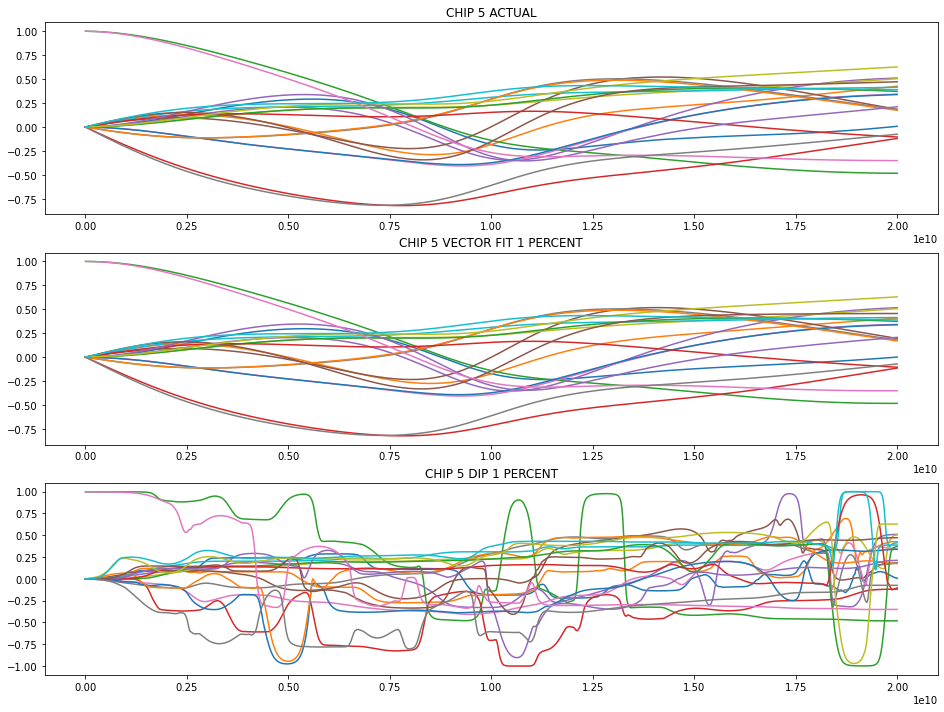

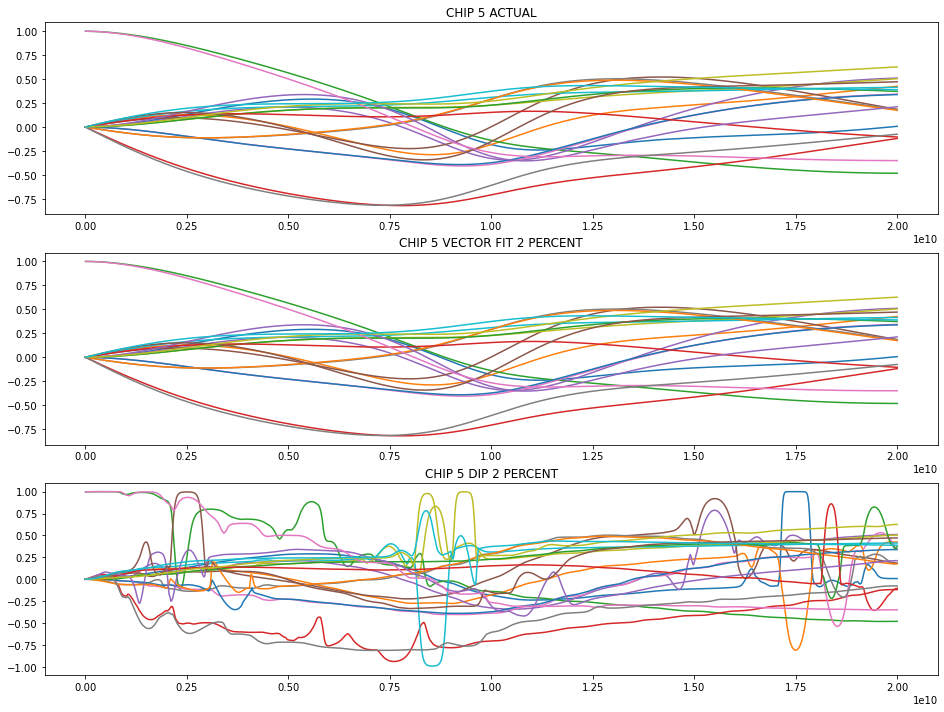

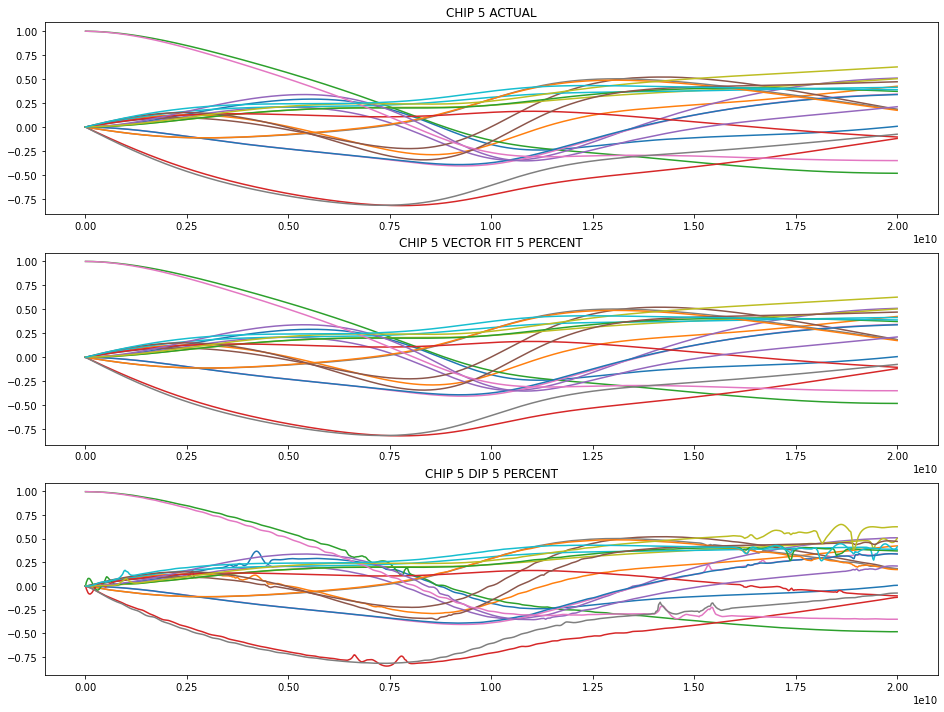

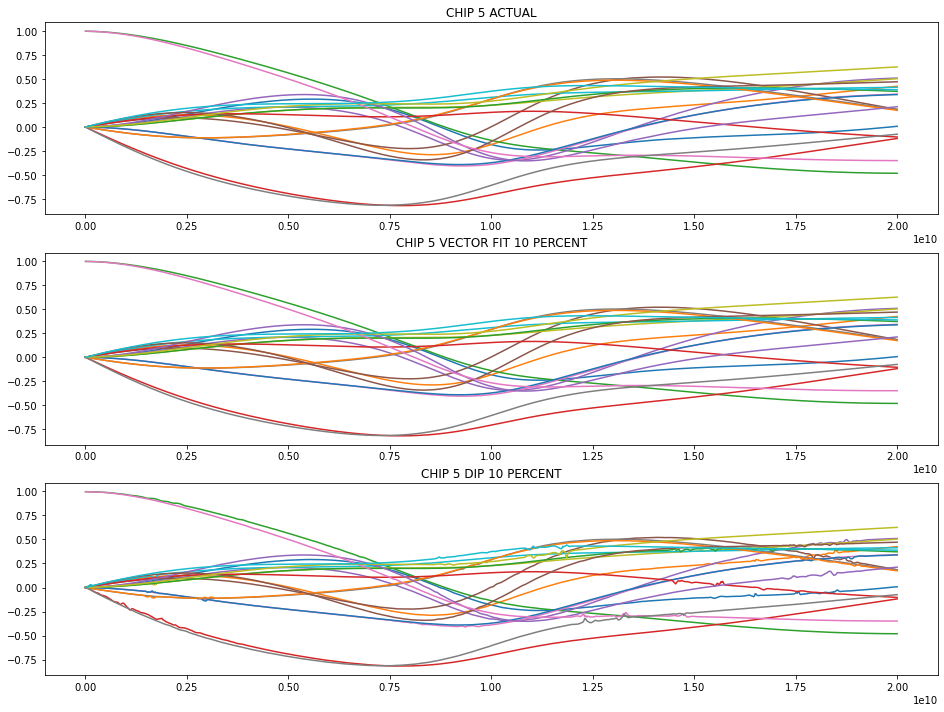

CHIP  7
LENGTH:  1000


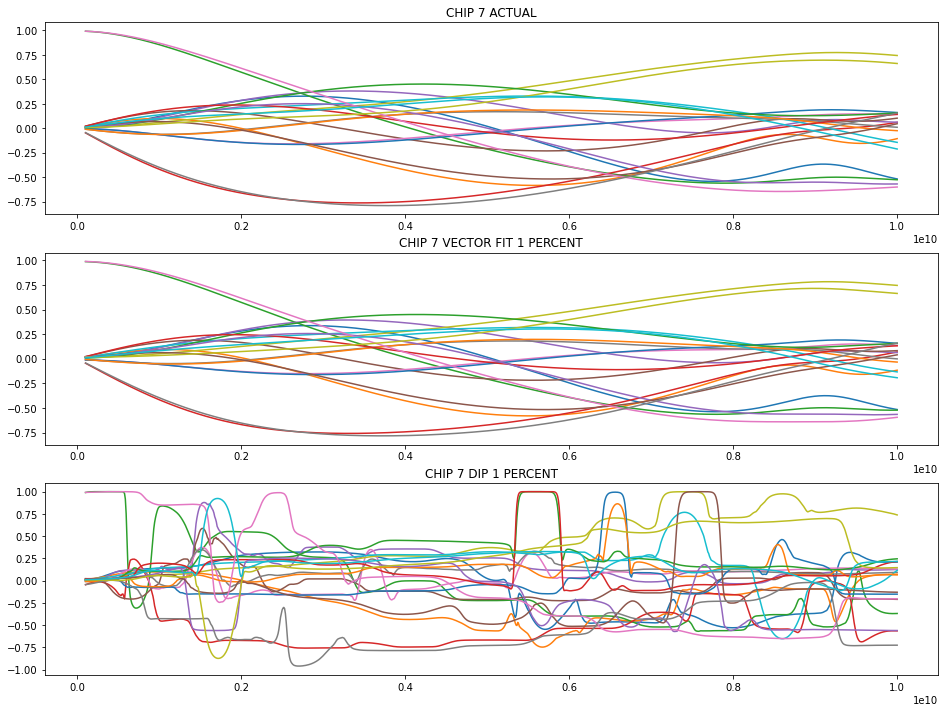

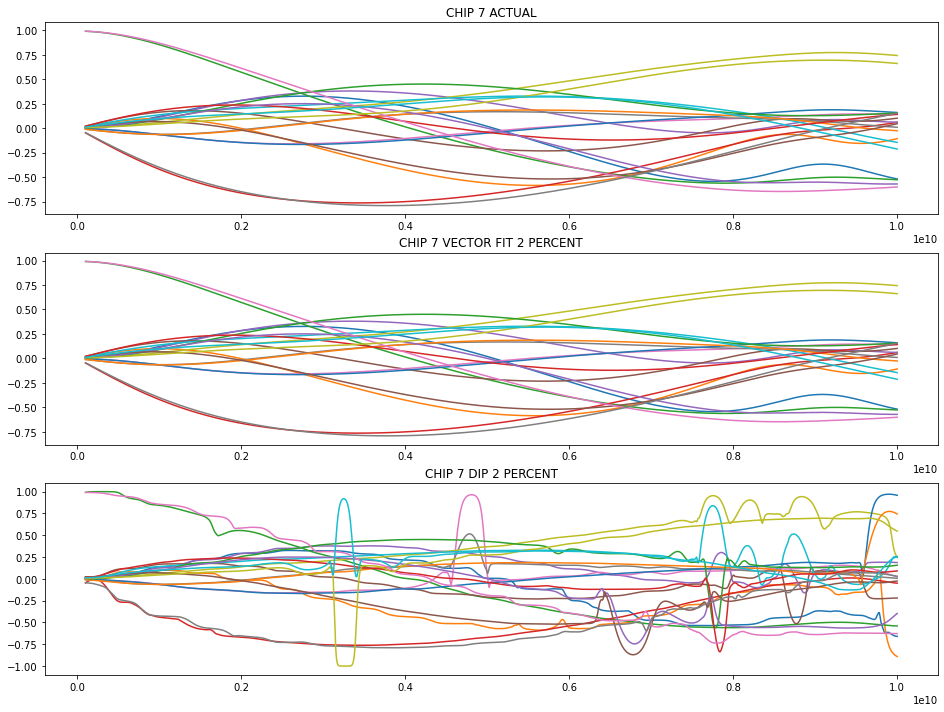

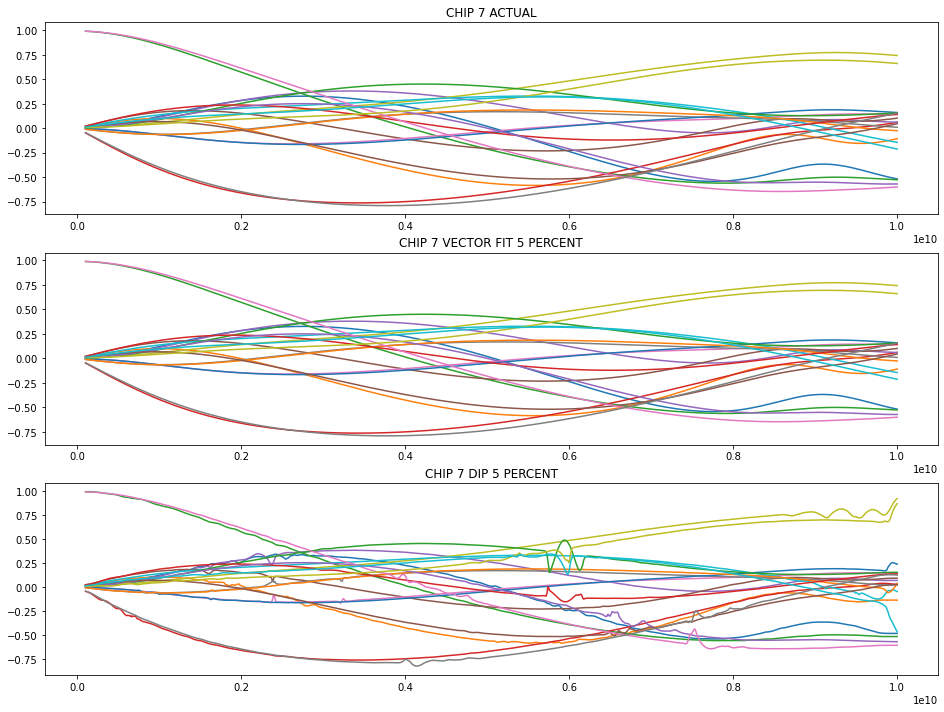

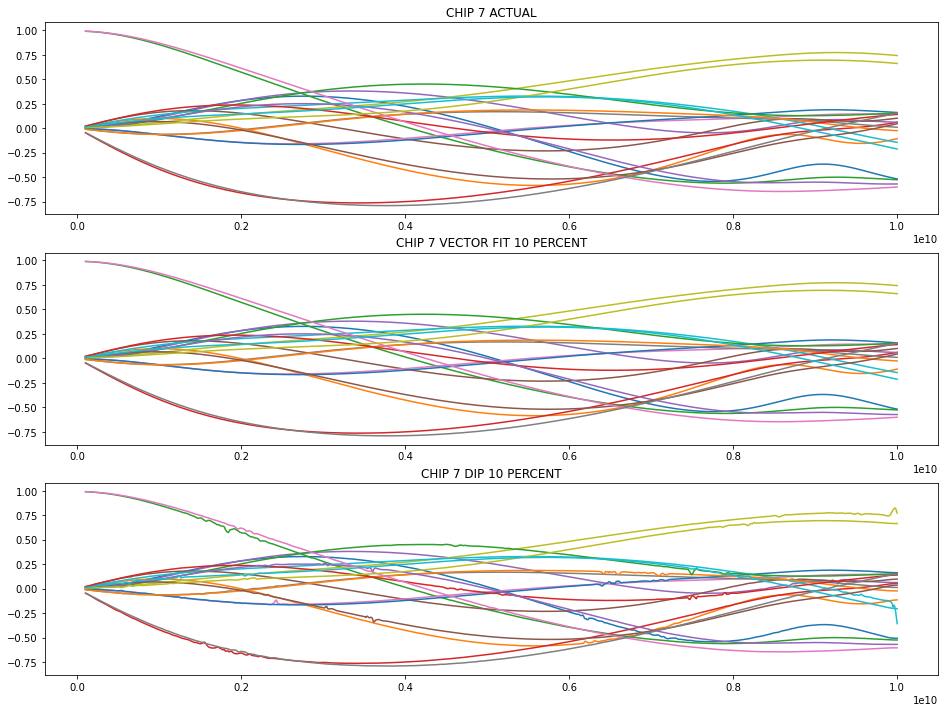

CHIP  9
LENGTH:  1000


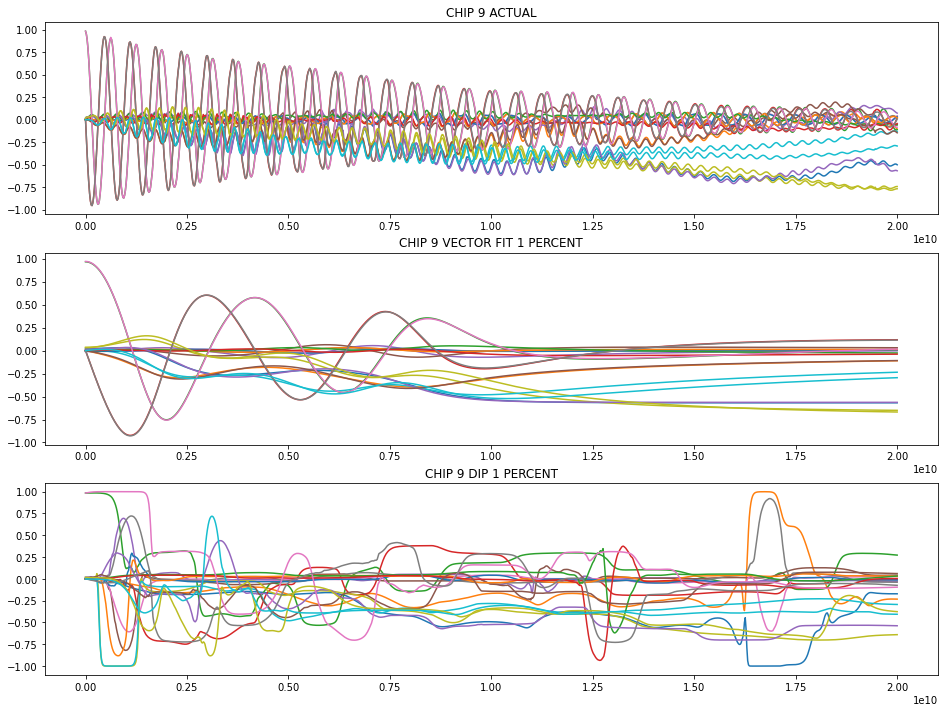

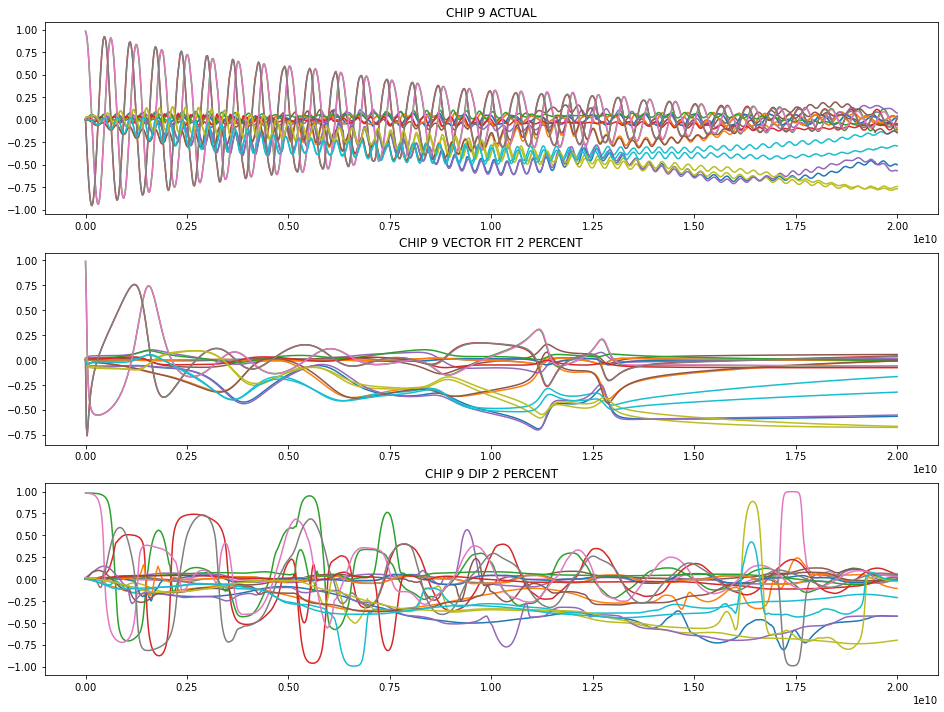

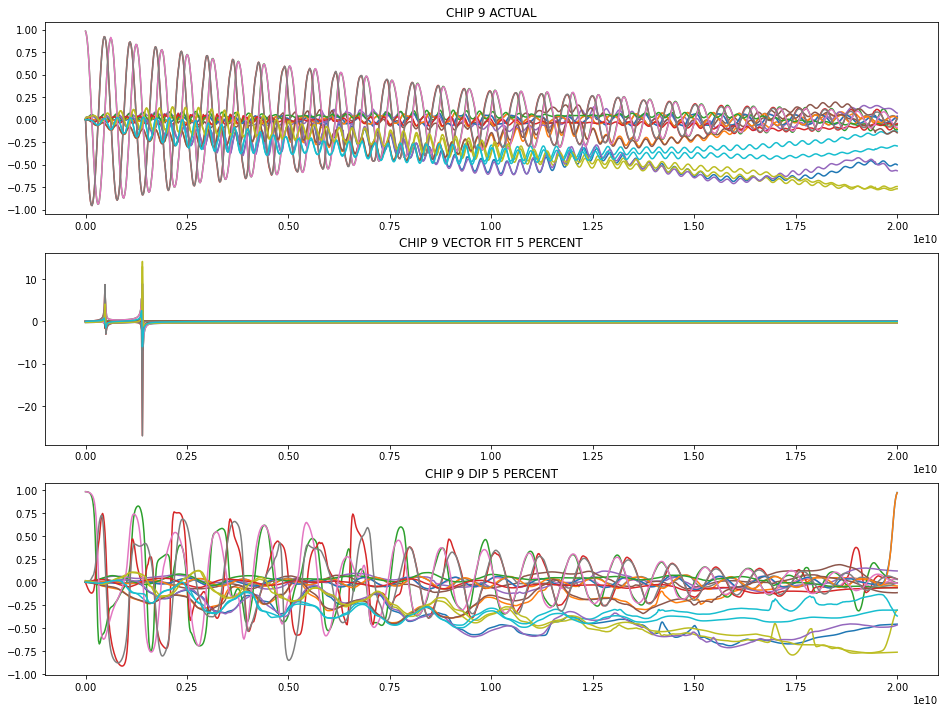

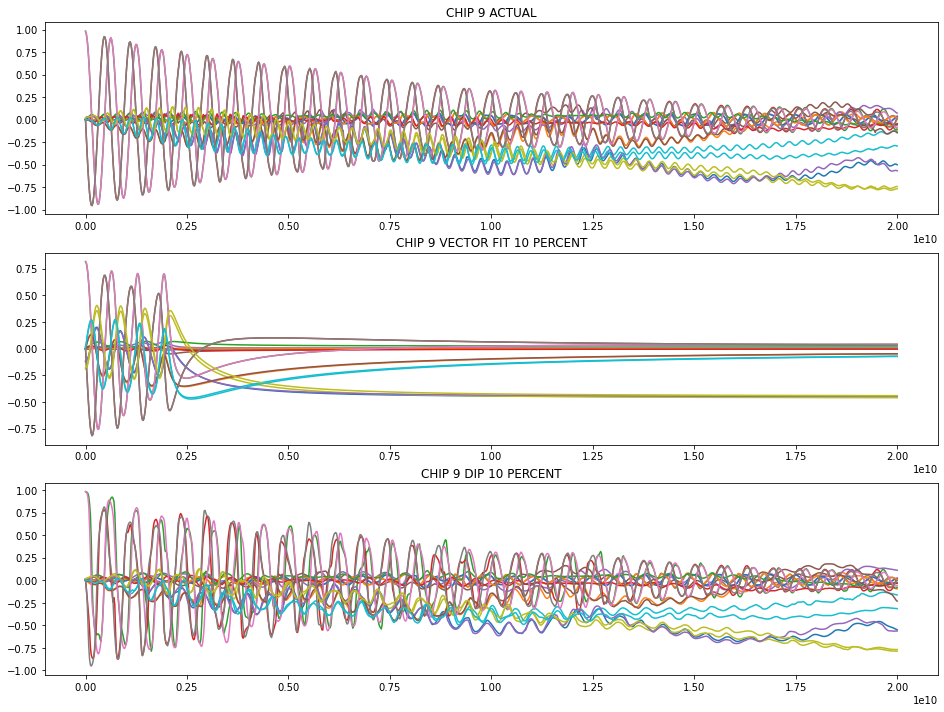

CHIP  10
LENGTH:  1000


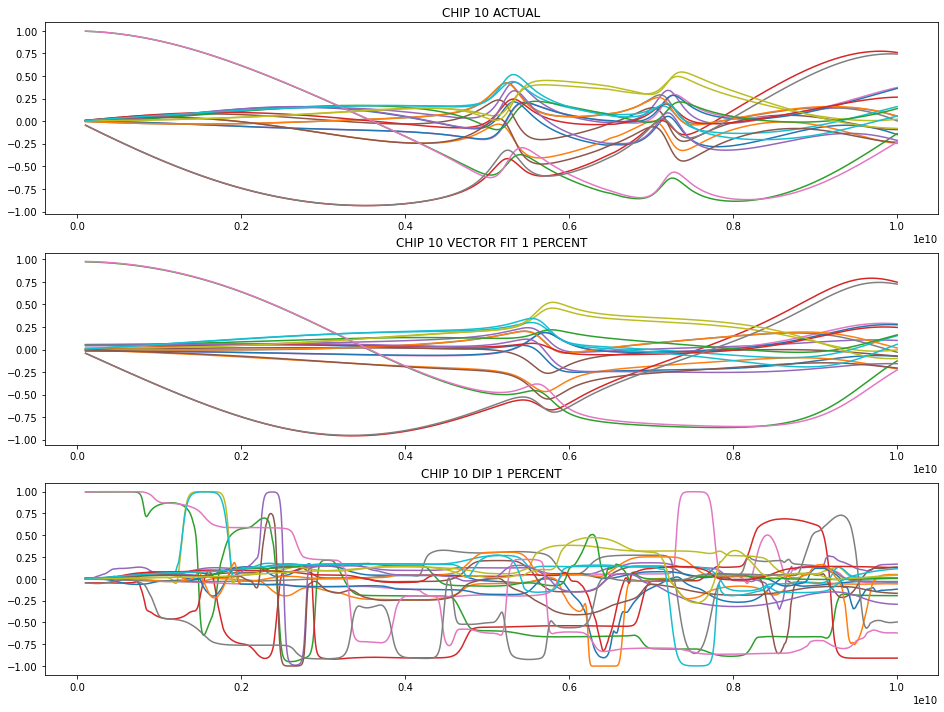

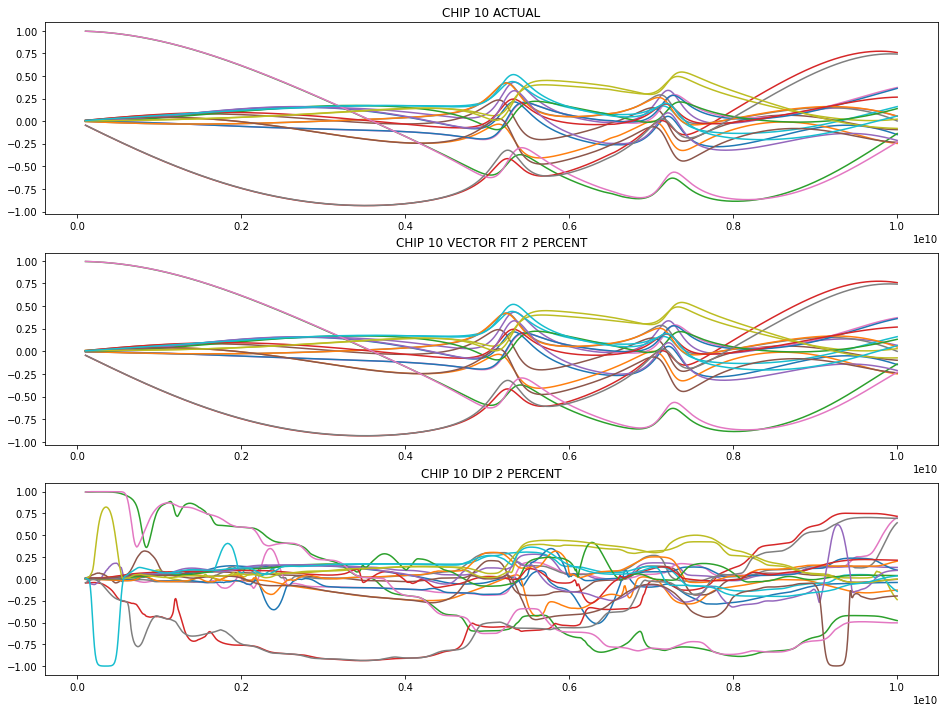

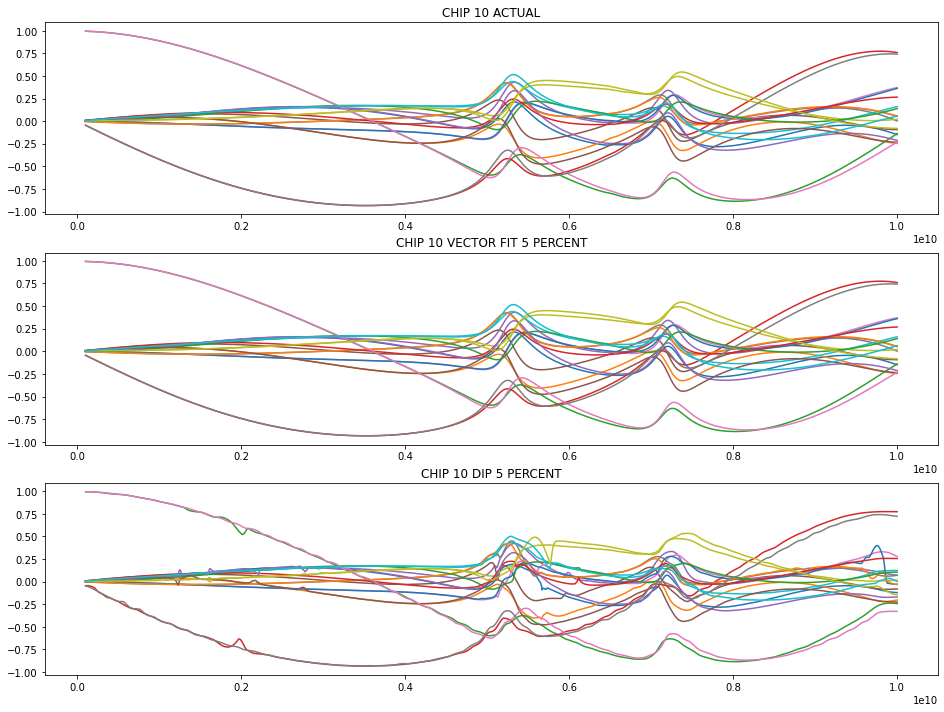

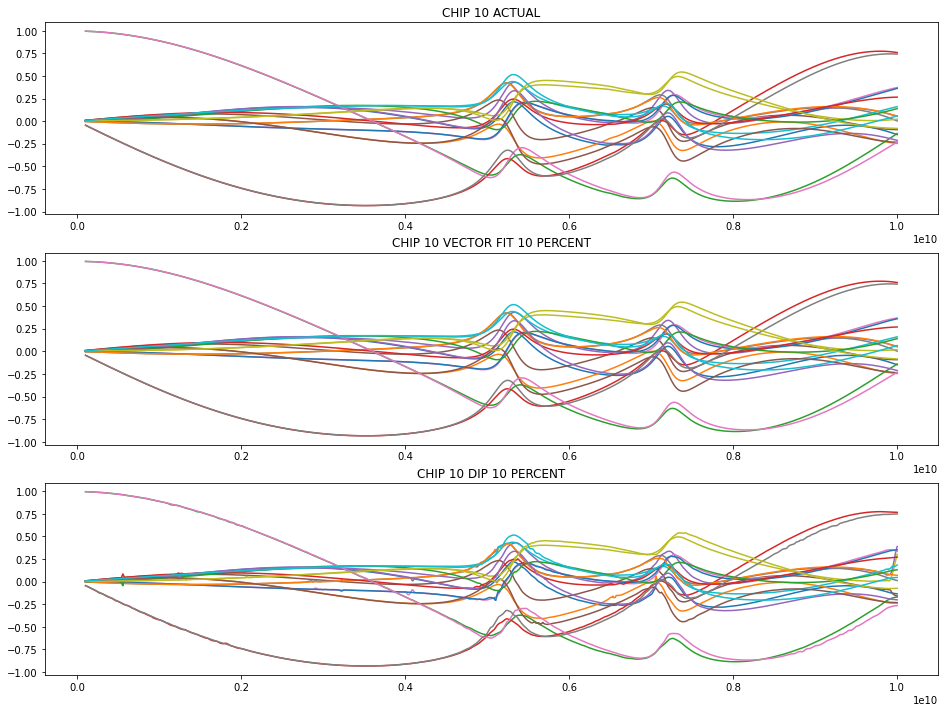

CHIP  15
LENGTH:  1000


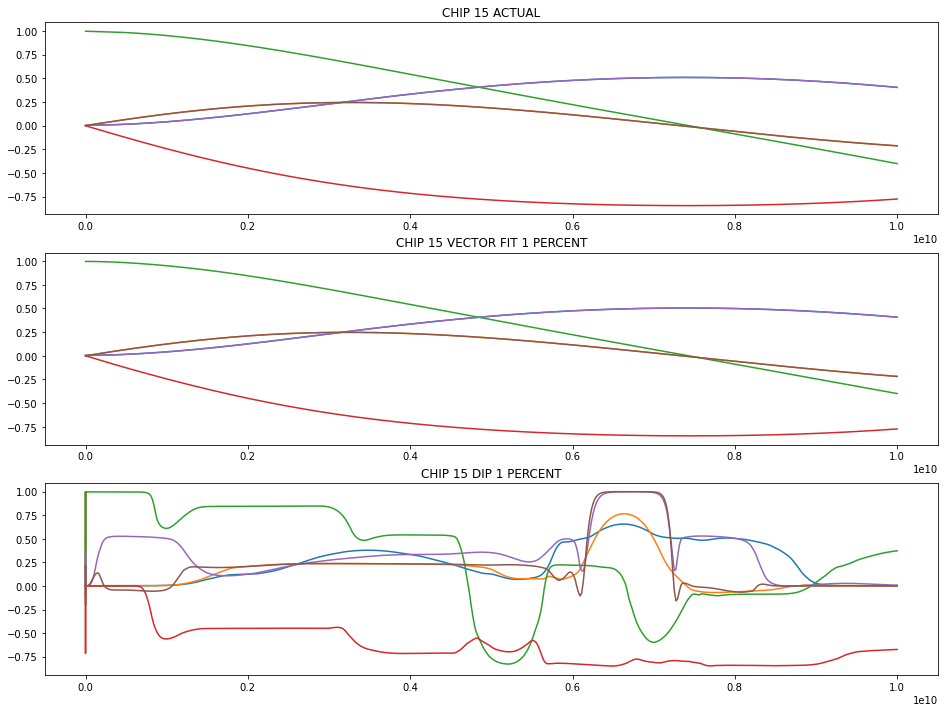

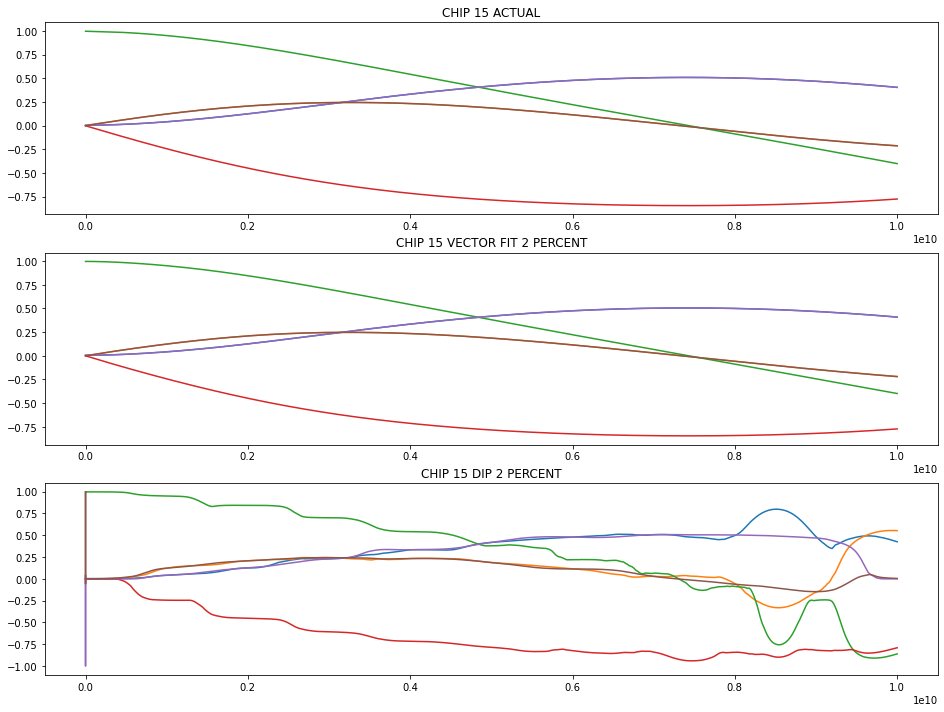

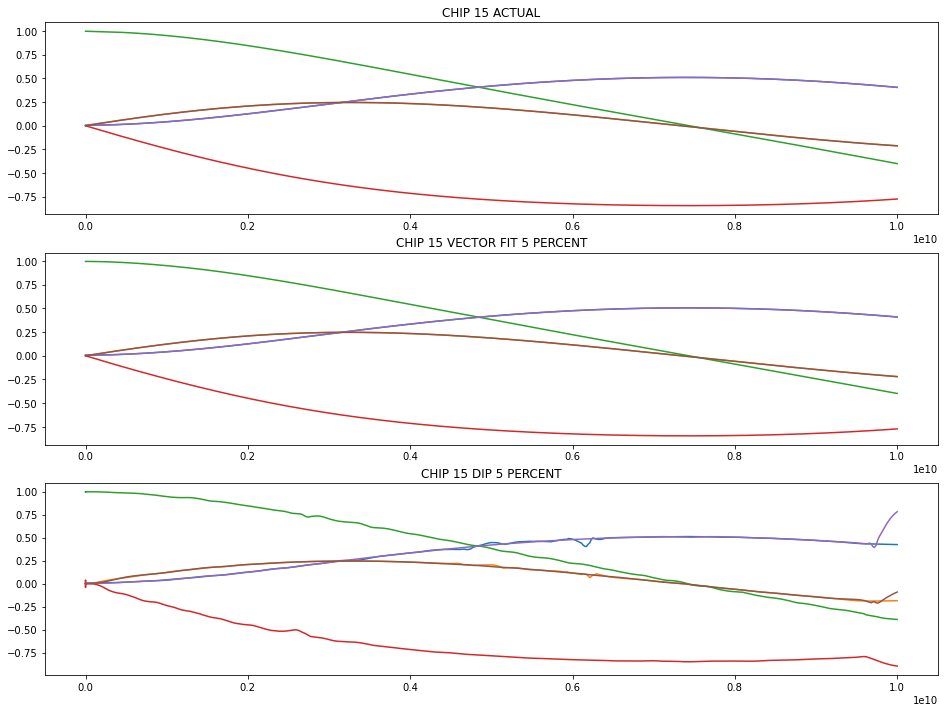

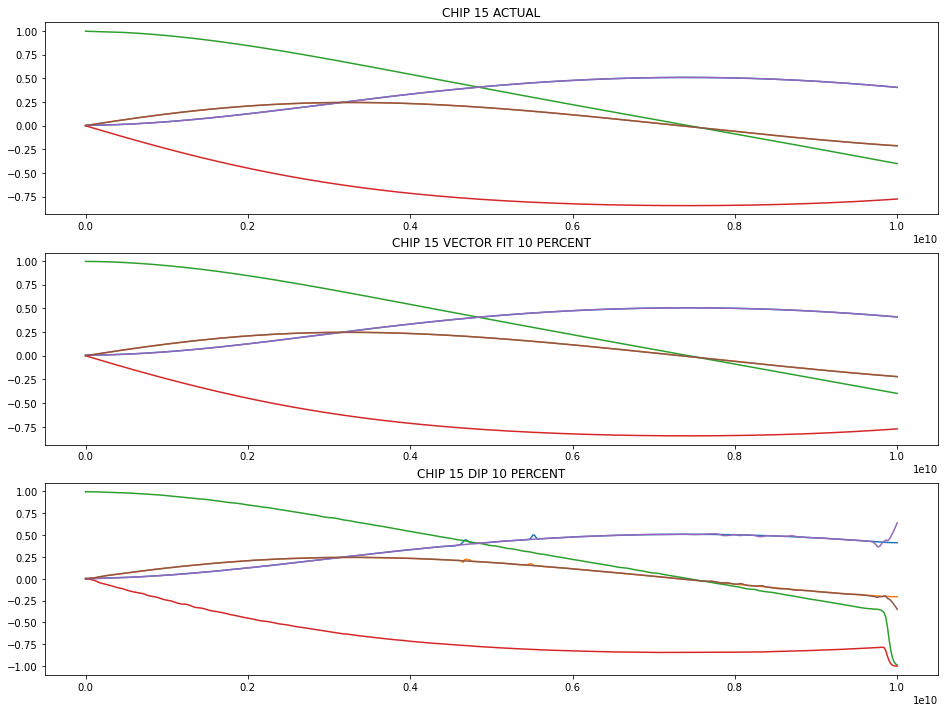

CHIP  20
LENGTH:  1500


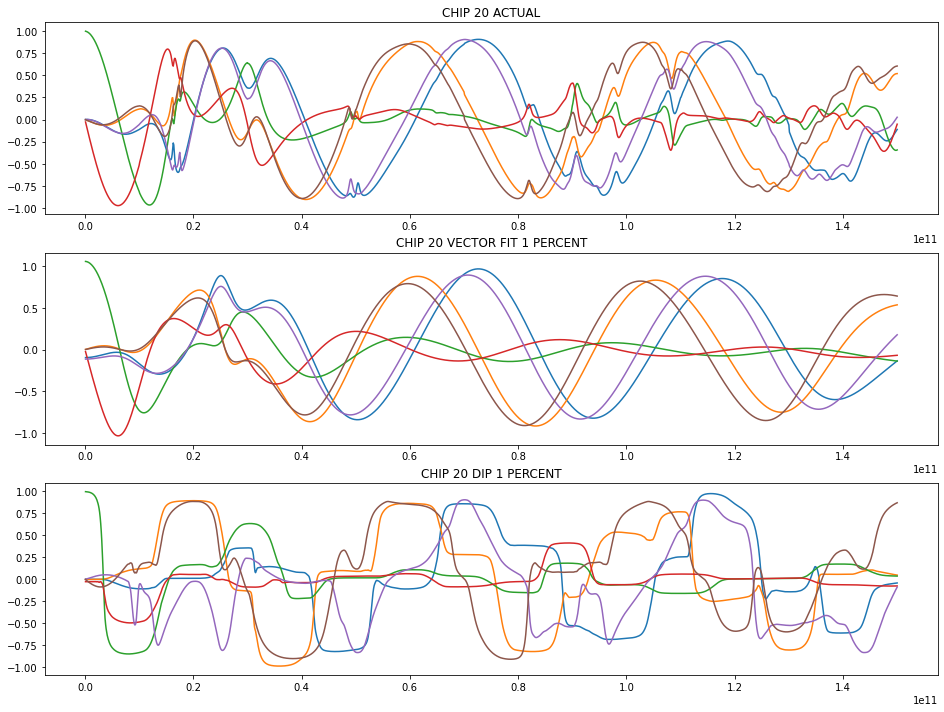

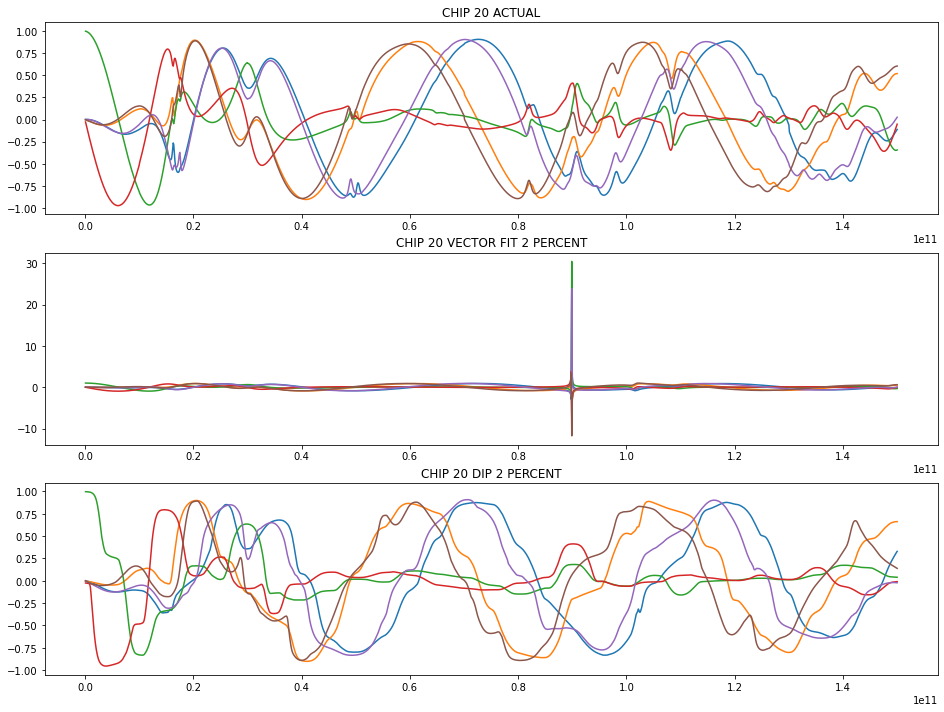

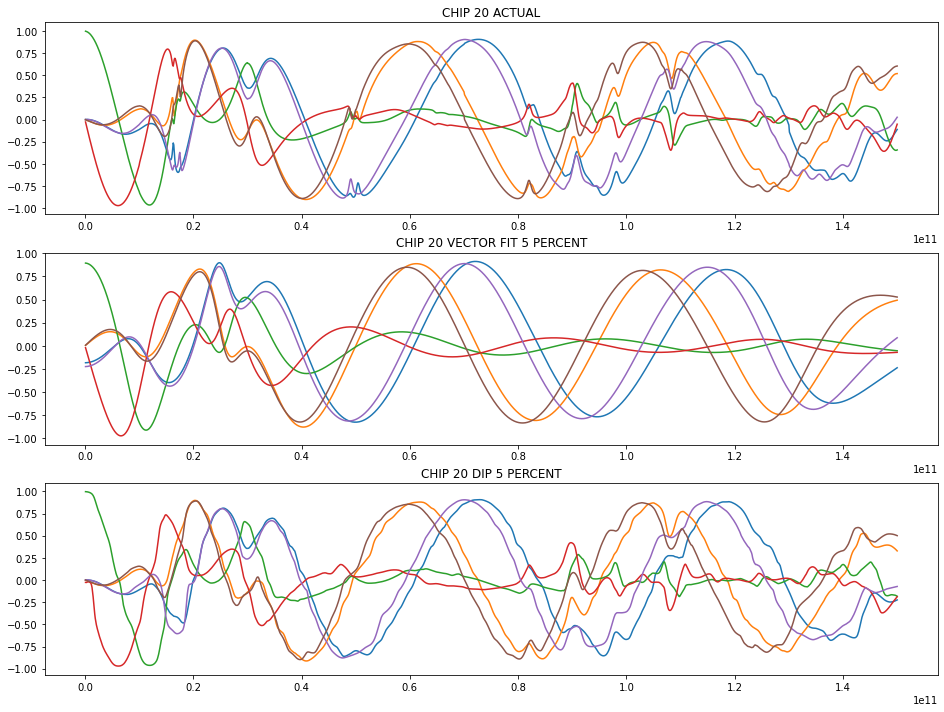

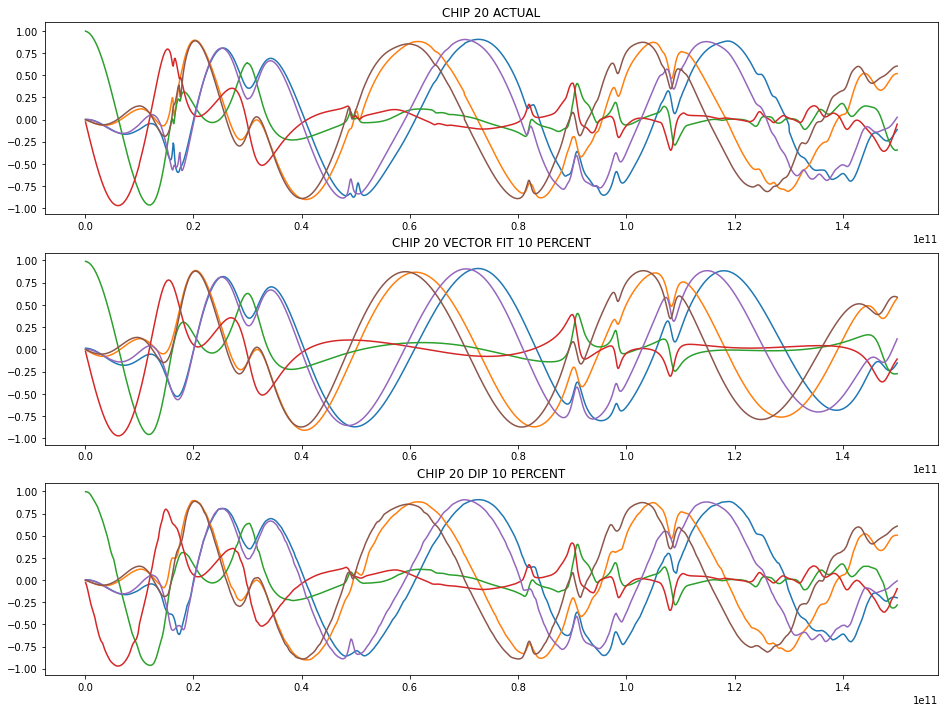

CHIP  23
LENGTH:  2081


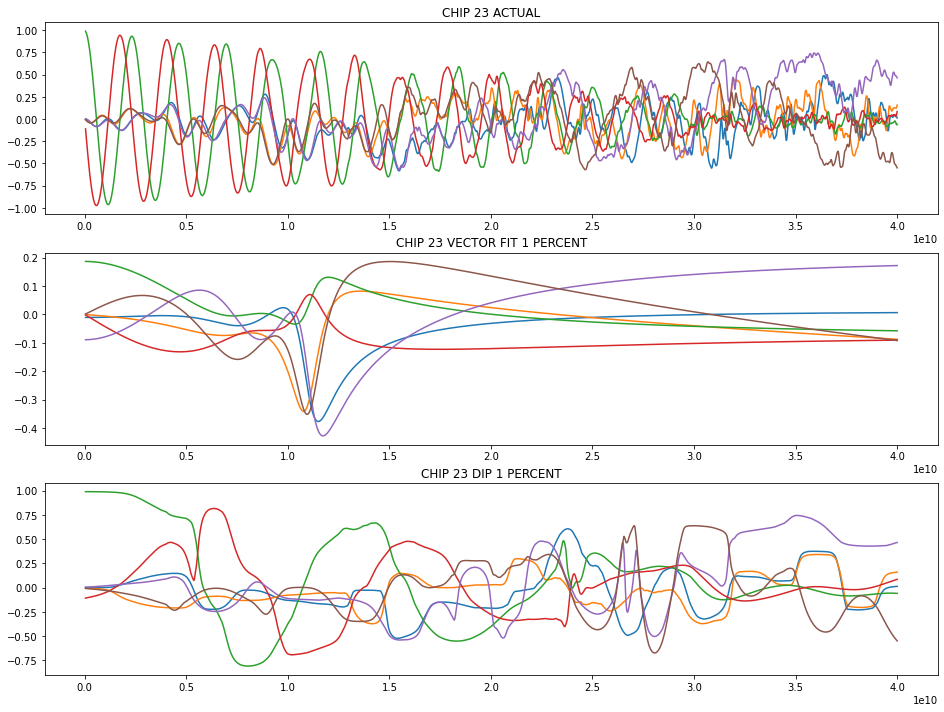

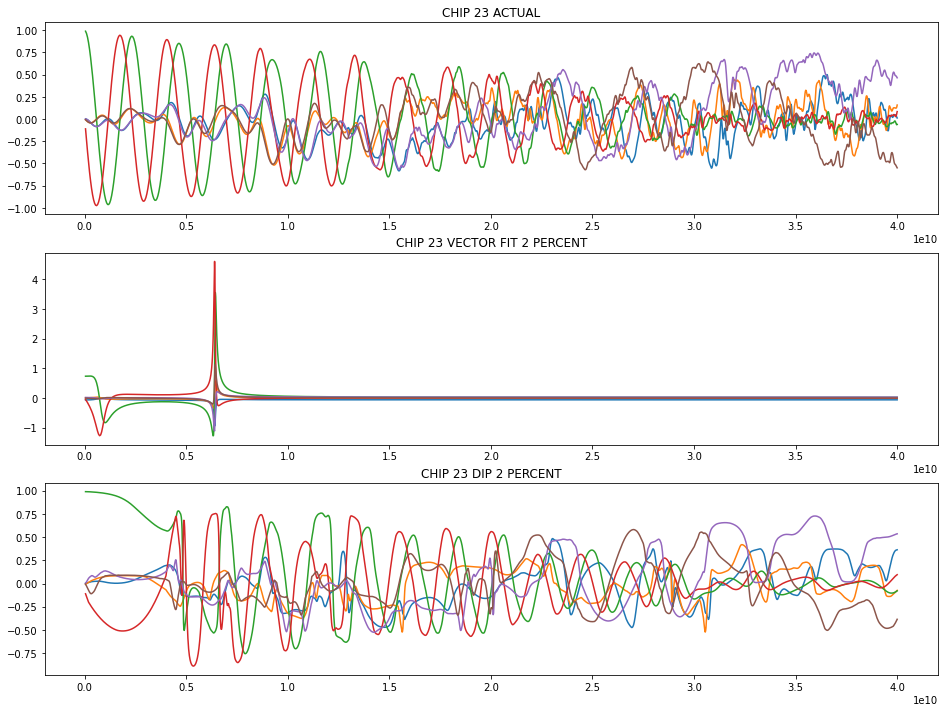

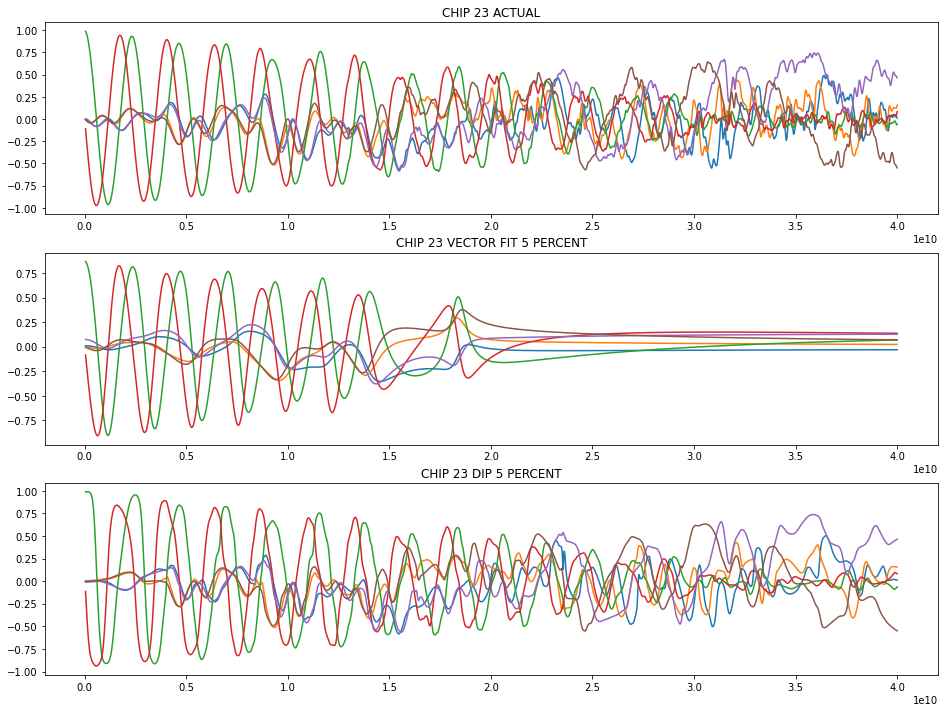

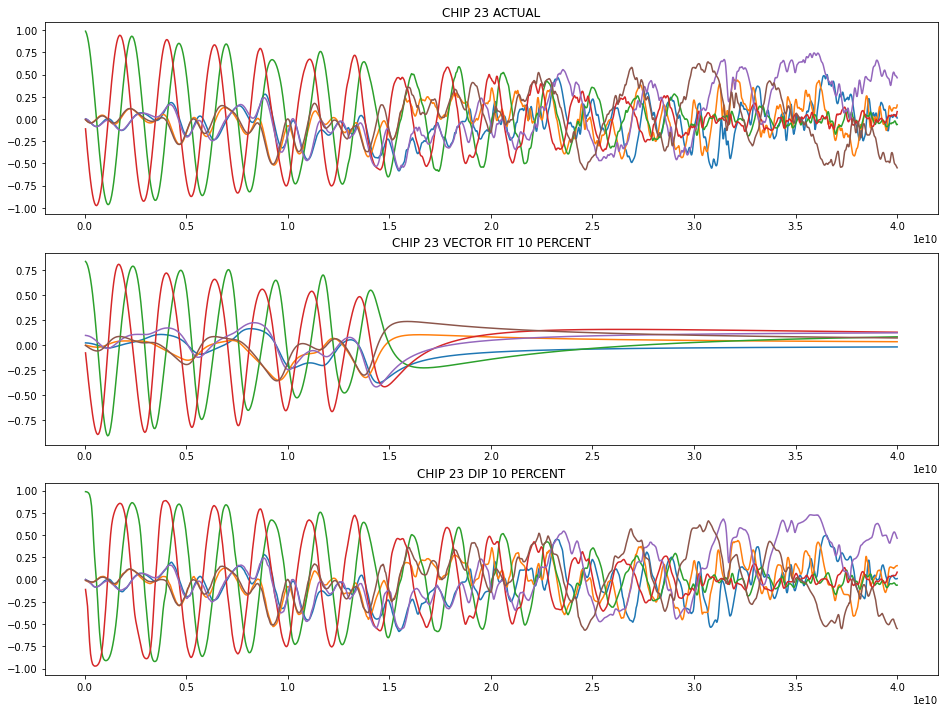

In [36]:
for i in range(len(VF_chips)):
    chip_num = VF_chips[i]
    
    GT = DATA[i]
    FREQS = FREQUENCIES[i]
    
    print("CHIP ", chip_num)
    print("LENGTH: ", len(FREQS))
    
    for j, pct in enumerate(PERCENTS):
        VF_OUT = VF_RESULTS[j][i]
        DIP_OUT = DIP_RESULTS[j][i]
        
        fig, axes = plt.subplots(3,1, figsize=(16, 12))
        axes = axes.flatten()

        for k in range(GT.shape[-1]):
            axes[0].plot(FREQS, GT[0,:,k], label="Real " + str(k))
            axes[0].plot(FREQS, GT[1,:,k], label="Imag " + str(k))
#         axes[0].legend()
        axes[0].set_title("CHIP " + str(chip_num) + " ACTUAL")
        
        for k in range(GT.shape[-1]):
            axes[1].plot(FREQS, VF_OUT[0,:,k], label="Real " + str(k))
            axes[1].plot(FREQS, VF_OUT[1,:,k], label="Imag " + str(k))
#         axes[1].legend()
        axes[1].set_title("CHIP " + str(chip_num) + " VECTOR FIT " + str(pct) + " PERCENT")
    
        for k in range(GT.shape[-1]):
            axes[2].plot(FREQS, DIP_OUT[0,:,k], label="Real " + str(k))
            axes[2].plot(FREQS, DIP_OUT[1,:,k], label="Imag " + str(k))
#         axes[2].legend()
        axes[2].set_title("CHIP " + str(chip_num) + " DIP " + str(pct) + " PERCENT")
        
        plt.show()

# Finally, Calculate metrics